In [1]:
import csv
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
# use provided supplementary load function
from supp import pytorch_nn_spiral as iai

In [3]:
class ToyDataset(Dataset):
    """ A toy dataset class which implements the abstract class torch.utils.data.Dataset .
    (for reference see http://pytorch.org/docs/master/data.html#torch.utils.data.Dataset)
    """
    def __init__(self, root_dir, txt_filename):
        super(ToyDataset, self).__init__()
        
        with open(root_dir + "/" + txt_filename) as txt_file:
            content = csv.reader(txt_file, delimiter = ' ')
            x = []
            y = []
            truth = np.array([],dtype=int)
            for row in content:
                x_i = row[0]
                y_i = row[1]
                t_i = row[2]
                
                x.append(x_i)
                y.append(y_i)
                truth = np.append(truth,t_i)
        self.raw = torch.from_numpy(np.transpose(np.array((x[:], y[:]), dtype=float)))
        truth = truth.astype(np.int)
        self.type = torch.from_numpy(self.one_hot_encode(truth))
            
    # write ground truth as one hot vector
    def one_hot_encode(self, x):
        n_values = np.max(x) + 1
        return np.eye(n_values, dtype=float)[x]

    def __getitem__(self, index):
        return self.raw[index], self.type[index]

    def __len__(self):
        return self.raw.__len__()

# Load triple junction example

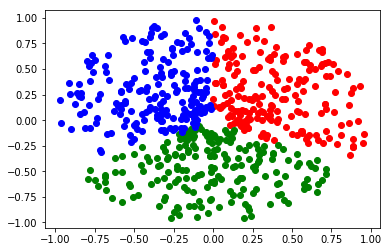

In [4]:
x,y = iai.load_dataset('supp/triple_junction_data_training.txt')
iai.visualize_toy_dataset(x, y)
plt.show()

In [5]:
toy = ToyDataset(root_dir='supp', txt_filename='triple_junction_data_training.txt')
#dir(toy)

def pred_quality(y1, y2):
    y1, y2 = y1.data.numpy(), y2.data.numpy()
    ix1 = y1.argmax(1)
    ix2 = y2.argmax(1)
    return float(np.sum(ix1 == ix2)) / y1.shape[0]

In [6]:
#labels = Variable(torch.FloatTensor([1, 2, 3])).view(1,-1)


N, D_in, H, D_out = toy.__len__(), toy.raw.shape[1], 100, 4

x = Variable(toy.raw)
y = Variable(toy.type)
x,y = x.type(torch.FloatTensor), y.type(torch.FloatTensor)

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax(),
)
loss_fn = torch.nn.MultiLabelSoftMarginLoss()

In [7]:
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = Variable(torch.FloatTensor([1000]))
#while float(loss.data) > 1:
for t in range(5000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 1000 == 0:
        print('Training acceptance: ', pred_quality(y_pred, y))
        print('Loss: ', loss.data)

    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    optimizer.step()
#torch.save(model.state_dict(), 'net2.pk1')

/Users/lucasmueller/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training acceptance:  0.3333333333333333
Loss:  
 0.7616
[torch.FloatTensor of size 1]

Training acceptance:  0.5066666666666667
Loss:  
 0.7420
[torch.FloatTensor of size 1]

Training acceptance:  0.63
Loss:  
 0.7181
[torch.FloatTensor of size 1]

Training acceptance:  0.685
Loss:  
 0.6955
[torch.FloatTensor of size 1]

Training acceptance:  0.85
Loss:  
 0.6757
[torch.FloatTensor of size 1]



# Training Success

In [8]:
print('Training acceptance: ', pred_quality(y_pred, y))

Training acceptance:  0.95


# Test Success

In [9]:
toyTest = ToyDataset(root_dir='supp', txt_filename='triple_junction_data_test.txt')

xt = Variable(toyTest.raw)
yt = Variable(toyTest.type)
xt,yt = xt.type(torch.FloatTensor), yt.type(torch.FloatTensor)
y_predt = model(xt)
print('Testing acceptance: ', pred_quality(y_predt, yt))

Testing acceptance:  0.945


/Users/lucasmueller/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
